## SF Fireshed Model Prep
Here we develop the geospatial and tabular inputs required to drive the simulations.

### Load required libraries
A bit overkill at the moment -- will thin this down prior to finalization

In [1]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random, ast, csv, math

# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection

# ---- Geospatial utilities
from geoUtils import *

dataDir = 'V:/SFFireshed/'
rasters = dataDir + 'inputRasters/'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


### Define the analysis extent
and look at the extent in the context of the greater geographic area. 
The SF fireshed, as its being modeled here, is roughly 43,000 ha, and contains vegetation types
ranging from Pinon-Juniper woodlands at the lower elevations, transitioning to Ponderosa Pine 
and ultimately, up to mixtures of sub-alpine fir and Engleman Spruce at higher elevations.

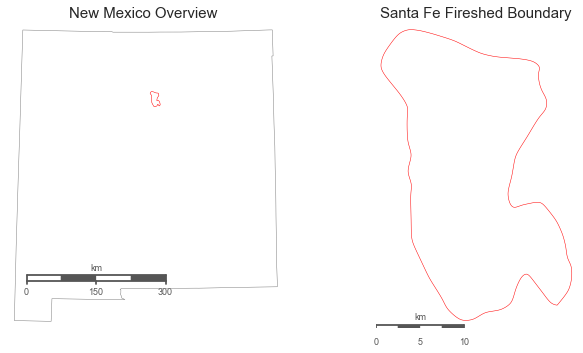

In [10]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
coords, midlat, midlon = getShpGeom(shapeDir + 'NM_NAD83.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(dataDir + 'NM_NAD83', 'NewMexico',
    color='gray', zorder=5);
m.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'SFFireshed',
    color='red', zorder=5);

m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(shapeDir + 'GSFCC_Boundary_NAD83.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(dataDir + 'GSFCC_Boundary_NAD83', 'GSFCC',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.055, coords[1] + 0.00,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('New Mexico Overview', fontsize = 15)
ax2.set_title('Santa Fe Fireshed Boundary', fontsize = 15)
plt.tight_layout()
sns.set_style('white')
sns.despine(left = True, bottom = True)

### Ecoregion creation
LANDIS-II requires the landscape be separated into edaphically and climatically distinct chunks. For this study we used STATSGO and USGS data to delineate the landscape into areas of unique soil composition, and distinct elevation bands that follow clear ecotones across the landscape. The logic here being that vegetation transitions and climate are well correlated with elevation across this fireshed. We then joined the soils components with the elevation bands to create the unique ecoregions for the fireshed.

Soils data were created using STATSGO (citation) data ....

Elevation bins were generated by looking at the intersection of 300 meter elevation contours across the fireshed (DEM downloaded from https://datagateway.nrcs.usda.gov/), and the distribution of forest types based on the Southwest Regional Gap Classification (downloaded from http://swregap.nmsu.edu/)

#### Import and fix up the raster data
I classified elevation (binned into four distinct bands that correlate with vegetation ecotones) on a scale of 100 to 400. These thematic lables correspond to XX, XX, XX, and XX meter elevation contours. In this manner, the six distinct soil types (here represented as values 1-6, described below) can be crossed with each elevation band to create unique soil, elevation combinations -- here referred to as ecoregions.

In [30]:
elevation  = importRaster(rasters + 'elevationBins.tif')
soils      = importRaster(rasters + 'soilBins.tif')
ecoregions = importRaster(rasters + 'SFF_ecoregions.tif')

soils[soils == 255] = 0

We need to do some color map trickery in order to visualize the ecoregions here, given that the thematic values are discontinuous and range from 105-405, with a sort of macro/micro class setup that I designed to make the raster math simple

In [51]:
from matplotlib import colors
cmap = colors.ListedColormap(['white','#969696','#636363',
                              '#edf8e9','#c7e9c0','#a1d99b','#74c476','#31a354','#006d2c',
                              '#f2f0f7','#dadaeb','#bcbddc','#9e9ac8','#756bb1','#54278f',
                              '#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c'])
bounds=[0,105,106,
        201,202,203,204,205,206,
        301,302,303,304,305,306,
        401,402,403,404,405]
norm = colors.BoundaryNorm(bounds, cmap.N)

####Visualize the three rasters 

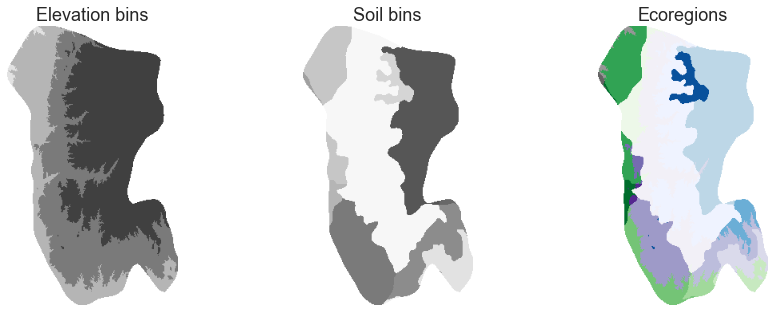

In [52]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plotRaster(elevation,  vmin = 0, vmax = 500, ax = ax1)
plotRaster(soils,      vmin = 0, vmax = 15,  ax = ax2)
plotRaster(ecoregions, cmap = cmap, norm = norm, ax = ax3)

ax1.set_title('Elevation bins')
ax2.set_title('Soil bins')
ax3.set_title('Ecoregions')

### Initial communities
A second major challenge to initializing the modeling environment for LANDIS-II simulations is the creation of an initial communities layer. This raster is a spatial lookup table for the species and age demographics in each pixel. 

We used the southwest regional gap classification to bin the landscape into three dominant cover types: Pinon-juniper woodlands, ponderoda pine, and mixed conifer ecosystems. Within these bins, we ran independent generalized nearest neighbor imputations to predict FIA plot data given stacks of elevation, slope, and tasseled cap transformation rasters from a greenest pixel Landsat 8 composite.

--- info regarding TC raster creation <p>
--- GNN model info (CCA or RF?)

We developed age-diameter relationships for each species in the watershed represented in FIA plots. When then used these relationships on a per FIA plot basis to associate each pixel with a set of species and age cohorts. The results of the initial communities generation is shown below:

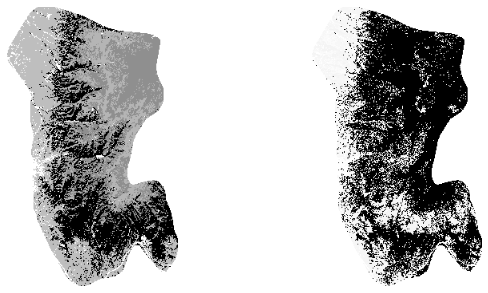

In [58]:
fortype  = importRaster(rasters + 'SFF_initialforesttypes.tif')
SFFic    = importRaster(rasters + 'SFF_initialcommunities.tif')

f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
plotRaster(fortype, vmin = 0, vmax = 500, ax = ax1)
plotRaster(SFFic,   vmin = 0, vmax = 500, ax = ax2)


### Climate configuration
Before we can spin up the model, we need to build  the climate files that will drive the growth and succession of the vegetation across the landscape. These files are specific to each ecoregion, and in the LANDIS-II PnET extension, the climate library afforded by other succession extensions is thrown to the wayside. That means we need a separate text file for each ecoregion. <p>

I chose to use LOCA statistical downscaling products based on CMIP5 projections. These can be downloaded using the climate data portal: https://cida.usgs.gov/gdp/. For more info on the LOCA project: http://loca.ucsd.edu/. <p>

The PnET extension also requires monthly average PAR and atmospheric [CO2]. This compounds the pain of assembling climate data, since there is no one stop shop for downscaled climate, PAR, and [CO2]. I chose to make use of shortwave radiation from Daymet (http://dx.doi.org/10.3334/ORNLDAAC/1328), and [CO2] from Mauna Loa (https://www.esrl.noaa.gov/gmd/ccgg/trends/data.html). <p>

So, the workflow here will be to use the same [CO2] and radiation time series for each LOCA projection, and have the projections Tmin, Tmax, and Precip provide the variability for growth and succession  over time.

In [34]:
# Start and grab the SW data, subset it to only grab mean values
simDir  = 'V:/SF_Fireshed_PnET_Sims/'
SW      = pd.read_csv(simDir + 'DAYMET_SW.csv', skiprows=1)
SWmu    = SW.loc[:, 'TIMESTEP':'MEAN(W/m2).18']

# Create an array of column headers
headers =['Time','105','106','201','202','203','204','205',
         '206','301','302','303','304','305','306','401',
         '402','403','404','405']
SWmu.columns = headers

# Read in the [CO2] data
CO2 = pd.read_csv(simDir + 'NOAA_CO2.csv', sep = ',')

# Read in the climate projection
loca_clim = pd.read_csv(simDir +'Access_Historical.csv', skiprows=2)
climdf    = loca_clim.dropna()

# Gather the index locations for the variable transition in the CDP files
# Here I'm using the repeated column header as an indication. 
varrows   = climdf[climdf['TIMESTEP'].str.match('TIMESTEP')]
precip    = climdf[:varrows.index[0]-2]
tamax     = climdf[varrows.index[0]-1:varrows.index[1]-4]
tamin     = climdf[varrows.index[1]-3:]

# Now we have to compute the monthly means from the daily vaules
# This means creating a timestamp as well.
#for df in [precip, tamax, tamin]:
#    df.columns = headers
#    df.index = pd.to_datetime(df.Time)
#    df = df.drop('Time', axis = 1).astype('float')

# ugly short term fix, will need a function workflow here
precip.columns = headers
precip.index = pd.to_datetime(precip.Time)
precip = precip.drop('Time', axis = 1).astype('float')
tamax.columns = headers
tamax.index = pd.to_datetime(tamax.Time)
tamax = tamax.drop('Time', axis = 1).astype('float')
tamin.columns = headers
tamin.index = pd.to_datetime(tamin.Time)
tamin = tamin.drop('Time', axis = 1).astype('float')
SWmu.index = pd.to_datetime(SWmu.Time)

precip['Year'] = tamax.index.year
precip['Month'] = tamax.index.month
tamax['Year'] = tamax.index.year
tamin['Year'] = tamin.index.year
tamax['Month'] = tamax.index.month
tamin['Month'] = tamin.index.month
SWmu['Month'] = SWmu.index.month
SWmu['Year']  = SWmu.index.year

pr   = precip.reset_index(drop=True)
tmax = tamax.reset_index(drop=True)
tmin = tamin.reset_index(drop=True)

prmu   = pr.groupby(['Year','Month']).sum().reset_index()
tmaxmu = tmax.groupby(['Year','Month']).mean().reset_index()
tminmu = tmin.groupby(['Year','Month']).mean().reset_index()
SWMmu  = SWmu.groupby(['Year','Month']).mean().reset_index()

### Now we need to create distributions of PAR from the shortwave 
data that we have. We need to populate the longer time series of the LOCA data with the shorter daymet shortwave. We also have to convert the shortwave data to an estimate of the portion of that radiation that is PAR. We're going to use a simple scalar to convert SW to PAR, and make the assumption that interanual variability PAR in an area is not changing signifncantly over the simulation period. The coefficients and explanation can be found here: <p>
Britton, C. M., and J. D. Dodd. Relationships of photosynthetically active radiation and shortwave irradiance. Agricultural Meteorology 17, no. 1 (1976): 1-7. 

In [4]:
earlyPad = SWMmu[SWMmu.Year < 2010]
earlyPad = earlyPad.ix[:, earlyPad.columns != 'Year']
earlyPad = earlyPad.ix[:, earlyPad.columns != 'Month']

yearMonth = prmu[prmu.Year <= 1979][['Year','Month']]
earlySW = pd.concat([earlyPad, yearMonth], axis = 1)
allSW = pd.concat([earlySW, SWMmu[SWMmu.Year < 2006]]).reset_index()
allCO2 = CO2[CO2.year < 2006].CO2

### Now we have to compile the component climate columns
into a text file that PnET requires

In [59]:
eco = '105'
climname = 'ACCESS_HIST'
ecodf = pd.DataFrame(dict(Year = tminmu.Year,
                  Month = tminmu.Month, 
                  TMax = tmaxmu[eco], 
                  TMin = tminmu[eco],
                  PAR  = allSW[eco],
                  PREC = prmu[eco],
                  CO2 = allCO2))
ecodf = ecodf.round(2)[['Year','Month','TMax','TMin','PAR','PREC','CO2']]
ecodf.Year[ecodf.Year == 1950] = '1600-1950'
ecodf.Year[ecodf.Year == 2005] = '2005-2050'

eco_climname = 'SFF_' + climname + '_' + eco + '.txt'
ecodf.to_csv(eco_climname)